### Feature scaling: Linear regression and KNN

The goal of this experiment is to see how the feature scaling affects linear regression and KNN algorithms

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pylab

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
df= pd.read_csv('basketball.csv')
df.head()

,position,number,name,height-in,weight-lb,age,from,team,salary-14-15
0,Forward,30,Brandon Bass,80,250,29,LSU,Boston Celtics,6900000
1,Guard,0,Avery Bradley,74,180,24,Texas,Boston Celtics,7191011
2,Forward-center,38,Vitor Faverani,83,260,26,Brazil,Boston Celtics,2090000
3,Forward,8,Jeff Green,81,235,28,Georgetown,Boston Celtics,9445000
4,Forward-center,41,Kelly Olynyk,84,238,23,Gonzaga,Boston Celtics,2075760


In [3]:
#rename the columns
df.columns = df.columns.str.replace('-', '_')
print(df.shape)
print(df.columns)

(447, 9)
Index(['position', 'number', 'name', 'height_in', 'weight_lb', 'age', 'from',
       'team', 'salary_14_15'],
      dtype='object')


### Clean and preprocess the data

### Missing values

In [4]:
# let's check the missing values in my dataset
nulls = df.isnull().mean()[df.isnull().mean()>0]

print("total number of columns: ", df.shape[1])
print('total number of columns with NA: ', len(nulls))
print('percentage of data without missing values: ', df.dropna().shape[0]/ np.float(df.shape[0]))
df.isnull().sum()

total number of columns:  9
total number of columns with NA:  0
percentage of data without missing values:  1.0


position        0
number          0
name            0
height_in       0
weight_lb       0
age             0
from            0
team            0
salary_14_15    0
dtype: int64

### Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset and inspect if they require any cleaning or pre-processing

In [5]:
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
num_vars

['number', 'height_in', 'weight_lb', 'age', 'salary_14_15']

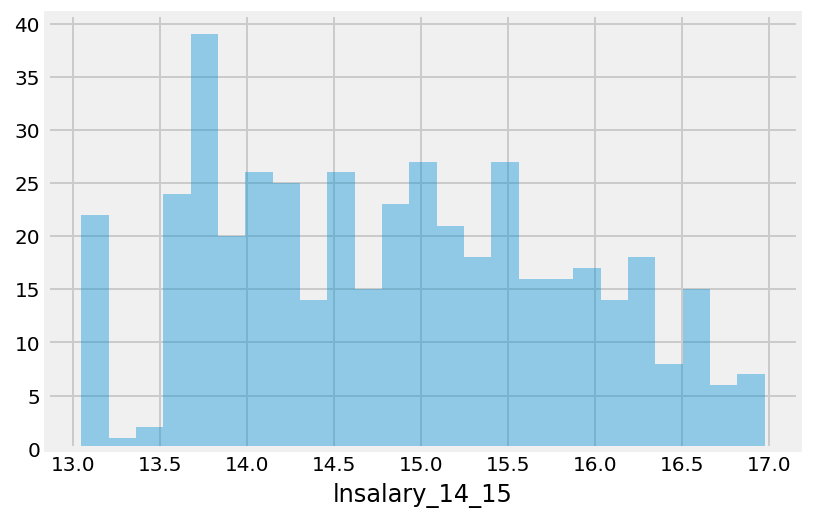

In [6]:
# natural log of house is more normally distributed, I will use this
df['lnsalary_14_15'] = np.log(df.salary_14_15+1)
sns.distplot(df.lnsalary_14_15, kde=False, bins=25);

##### Examine the distributions of the numerical variables 

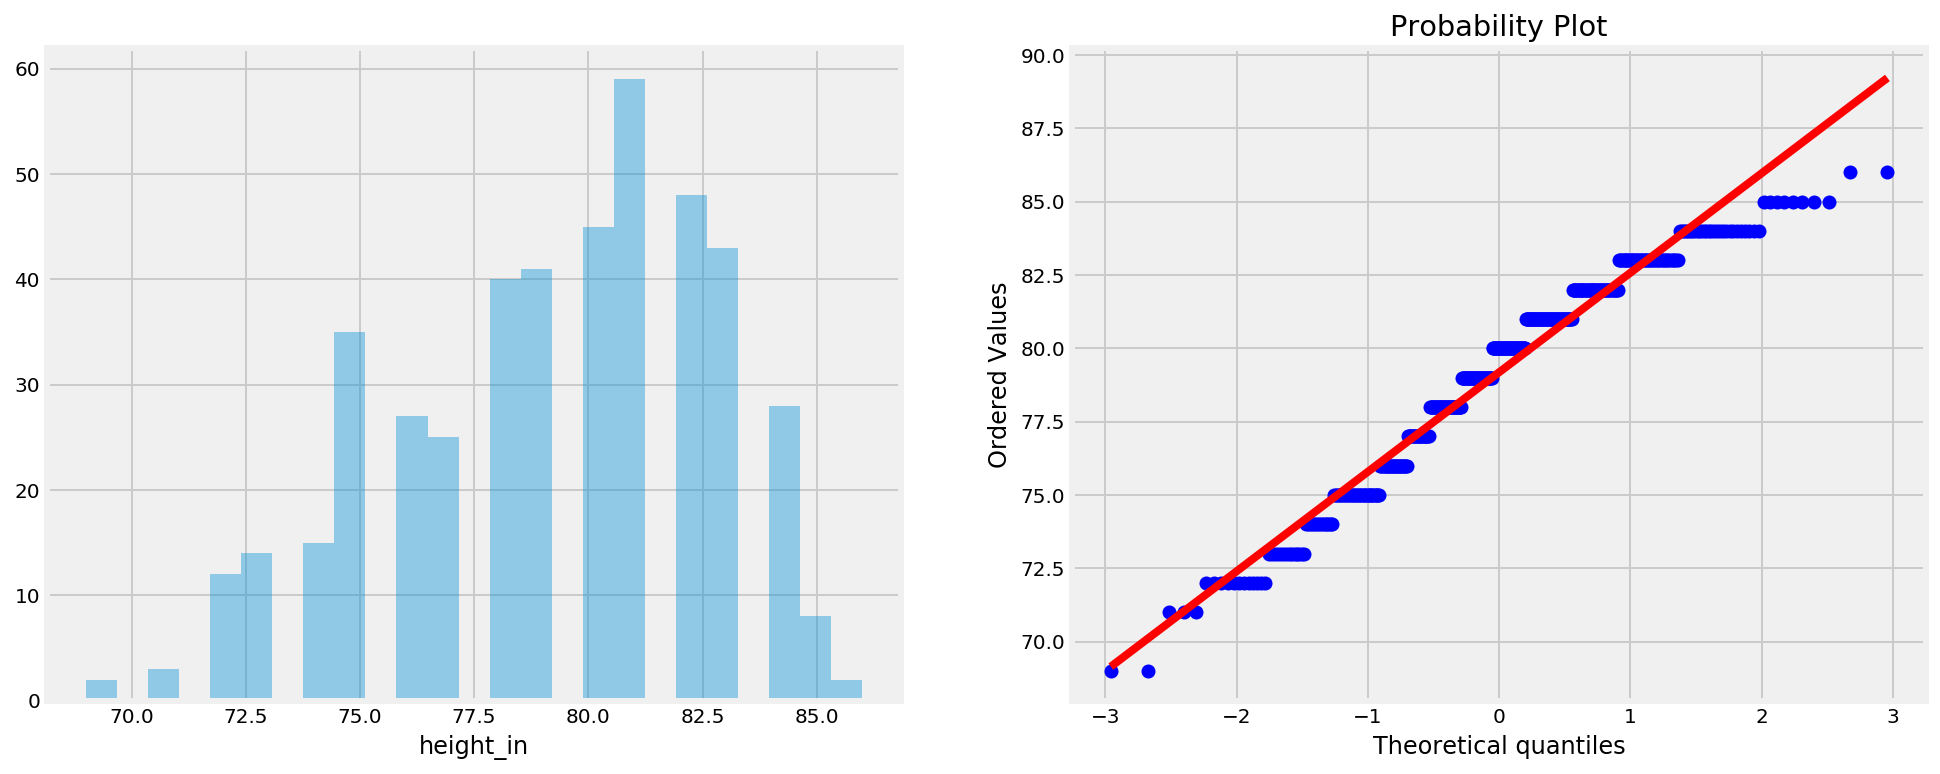

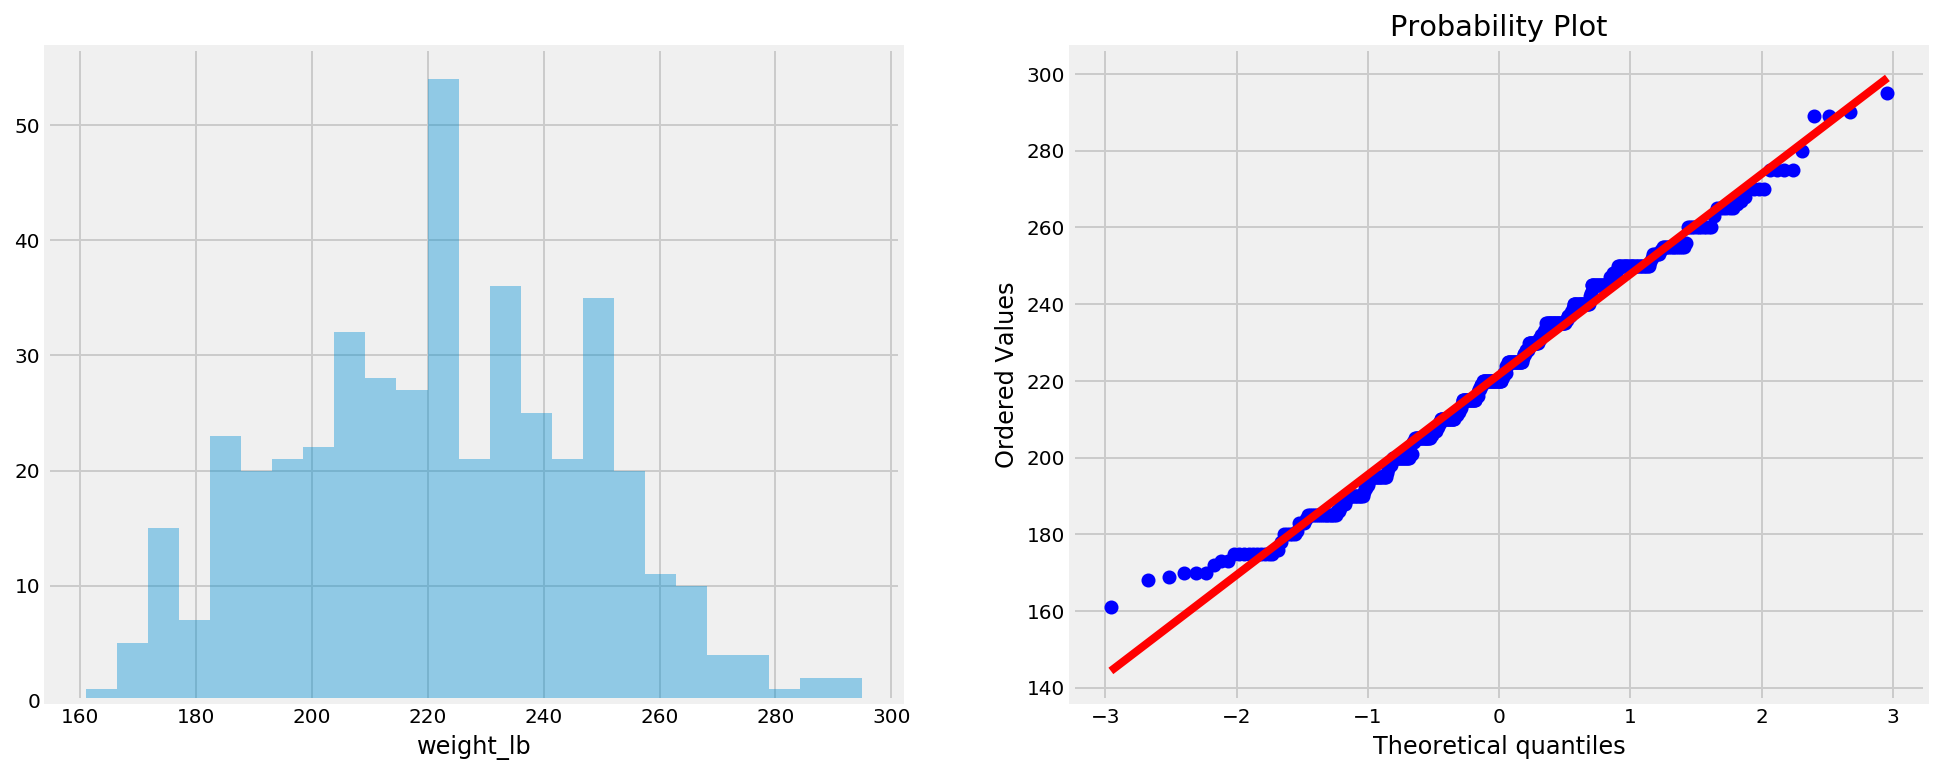

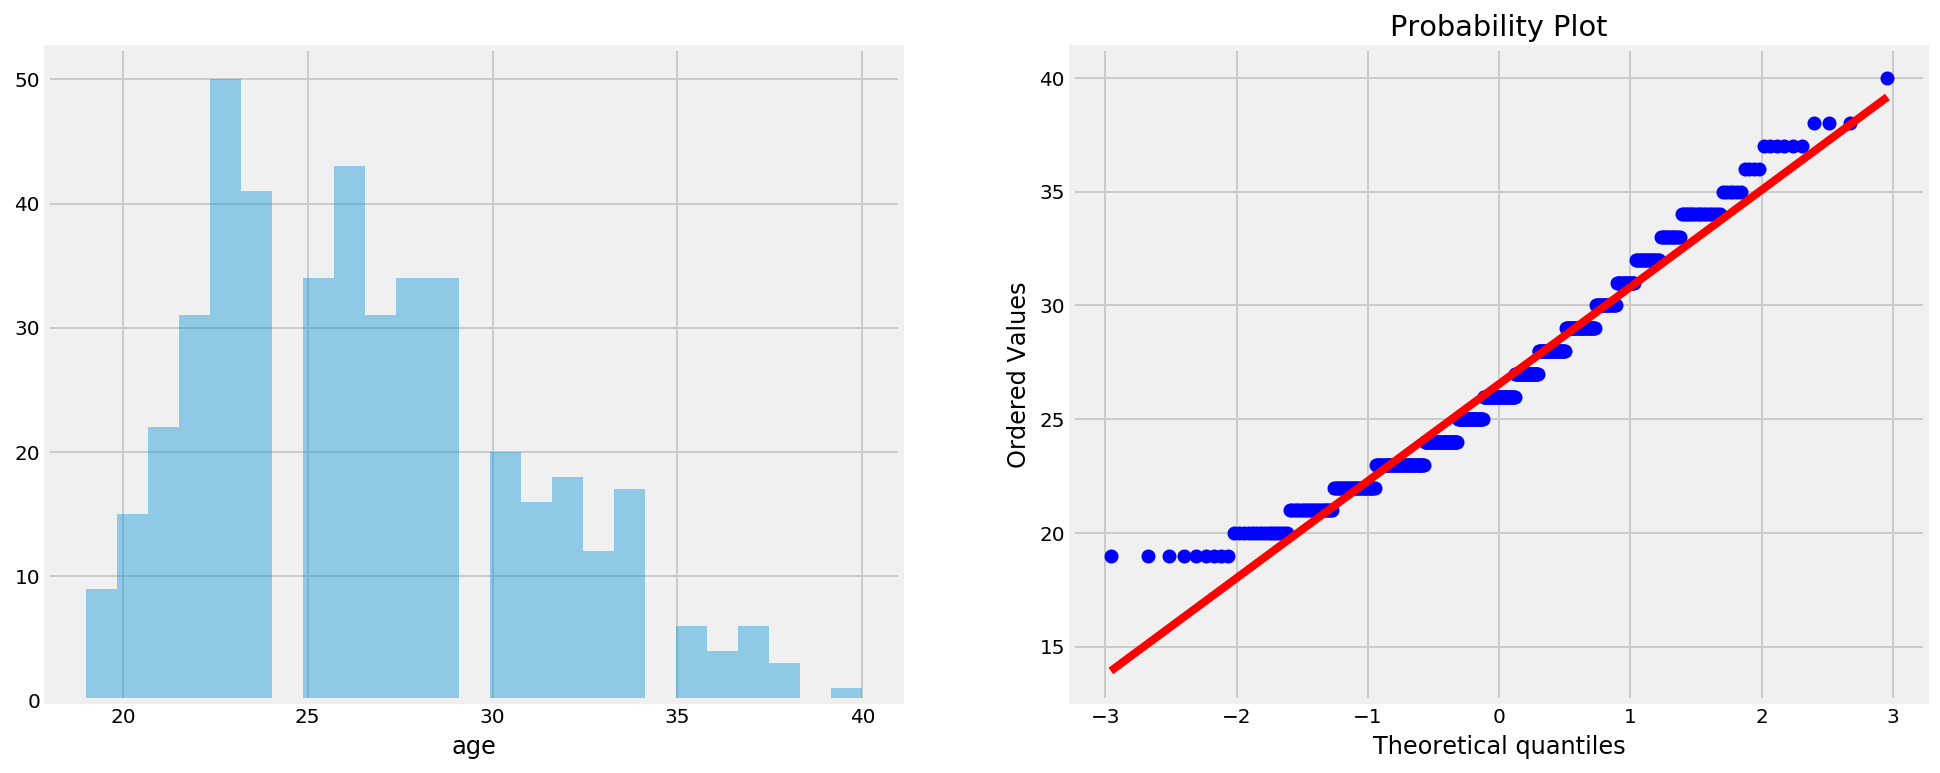

In [7]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    
    sns.distplot(df[variable], kde=False, bins=25);

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()

for var in ['height_in', 'weight_lb', 'age']:
    diagnostic_plots(df, var)

##### detect the outliers in numerical variables

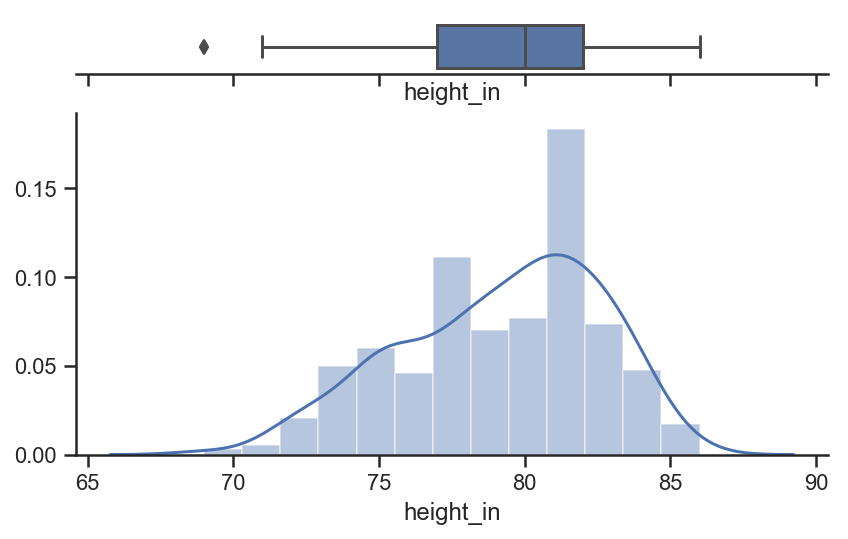

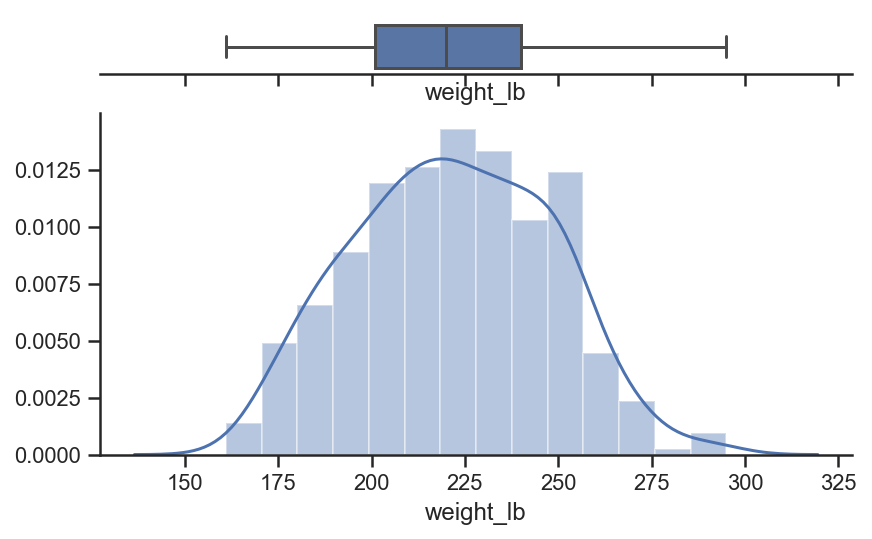

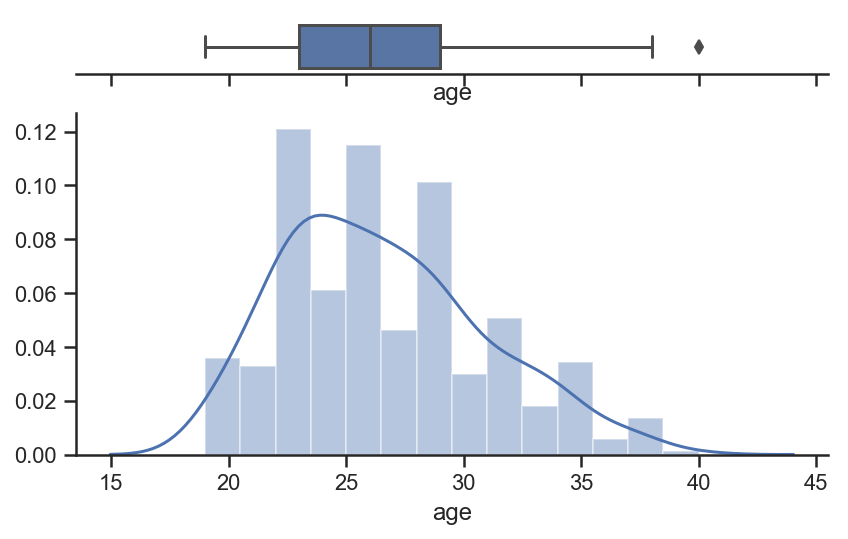

In [8]:
def detect_outliers(df, var):
    sns.set(style="ticks")

    x = df[var]

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .95)})

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
for var in [ 'height_in', 'weight_lb', 'age']:
    detect_outliers(df, var)

#### The correlation 

In [9]:
df[['height_in', 'age', 'weight_lb']].corr()

,height_in,age,weight_lb
height_in,1.000000,-0.018244,0.810057
age,-0.018244,1.000000,0.084290
weight_lb,0.810057,0.084290,1.000000


The predictors 'age' and 'height_in' have the small correlation between themselves 

#### Standardization and normalization of the predictors

I will scale the features using standardization and normalization and compare the results with the variables which weren't scaled. Then using cross-validation, I will calculate the average $R^2$ score for weight using the original predictors, the standardized predictors, and the normalized predictors.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df[['height_in', 'age']]
y = df['weight_lb']

ss = StandardScaler()
mms = MinMaxScaler()

Xs = ss.fit_transform(X)
Xn = mms.fit_transform(X)

In [11]:
#see the standarized predictors
standarized_predictors = pd.DataFrame(Xs, columns=X.columns)
standarized_predictors.head()

,height_in,age
0,0.237080,0.568604
1,-1.509755,-0.591971
2,1.110497,-0.127741
3,0.528219,0.336489
4,1.401636,-0.824086


In [12]:
#see the normalized predictors
normalized_predictors = pd.DataFrame(Xn, columns=X.columns)
normalized_predictors.head()

,height_in,age
0,0.647059,0.476190
1,0.294118,0.238095
2,0.823529,0.333333
3,0.705882,0.428571
4,0.882353,0.190476


In [13]:
lr = LinearRegression()
lr.fit(X, y)
print ('Intercept (original):', lr.intercept_)
print( 'Height coef (original):', lr.coef_)

lr = LinearRegression()
lr.fit(Xs, y)
print ('Intercept (standarized predictors):', lr.intercept_)
print( 'Height coef (standarized predictors):', lr.coef_)

lr = LinearRegression()
lr.fit(Xn, y)
print ('Intercept (normalized predictors):', lr.intercept_)
print( 'Height coef (normalized predictors):', lr.coef_)

Intercept (original): -282.99831590413135
Height coef (original): [6.17201514 0.60065718]
Intercept (standarized predictors): 221.6845637583893
Height coef (standarized predictors): [21.19953499  2.58775672]
Intercept (normalized predictors): 154.28321498081118
Height coef (normalized predictors): [104.92425733  12.6138008 ]


###### The predictors which weren't scaled
The intercept, -284, is the estimated weight of a baseball player when their height is 0 inches and age is 0 years.
The 6.17 coefficient on height is the number of pounds more a player is estimated to weigh for each inch of height. The 0.6 coefficient on age is the number of pounds more a player is estimated to weigh for each  year of age.

###### Standardization 
In standardization we first center the data, then we divide by the standard devation to enforce that the standard deviation of the variable is one:

$$ X_{std} = \frac{X - \bar{X}}{s_{X}} $$

The intecept (221,68) where the predictors were standarized, is interpreteed as the estimate when all predictors (age, hight) are at their mean value. Coefficients are in units of standard deviations of the original predictors. 

This allows for direct comparison of the magnitude of impact between different predictors.

In [14]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

raw_r2 = cross_val_score(lr, X, y, cv=10)
std_r2 = cross_val_score(lr, Xs, y, cv=10)
norm_r2 = cross_val_score(lr, Xn, y, cv=10)

print ('Original mean CV-R2:', np.mean(raw_r2), 'std CV-R2:', np.std(raw_r2))
print ('Standadized mean CV-R2:', np.mean(std_r2), 'std CV-R2:', np.std(std_r2))
print ('Normalized mean CV-R2:', np.mean(norm_r2), 'std CV-R2:', np.std(norm_r2))

Original mean CV-R2: 0.660207065984857 std CV-R2: 0.07910382509567104
Standadized mean CV-R2: 0.6602070659848571 std CV-R2: 0.07910382509567095
Normalized mean CV-R2: 0.6602070659848571 std CV-R2: 0.07910382509567132


### K-Nearest Neighbors

In K-Nearest Neighbors methods it is necessary to scale the predictors especially if we want features to contribute equally since these models use the distance between observations calculated from the features.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
raw_r2 = cross_val_score(knn, X, y, cv=10)
std_r2 = cross_val_score(knn, Xs, y, cv=10)

print ('Original mean CV-R2:', np.mean(raw_r2), 'std CV-R2:', np.std(raw_r2))
print ('Standadized mean CV-R2:', np.mean(std_r2), 'std CV-R2:', np.std(std_r2))

Original mean CV-R2: 0.04850570097824814 std CV-R2: 0.026341793017685168
Standadized mean CV-R2: 0.06057427698212109 std CV-R2: 0.034535547682729414


##### Find the best k for prediction

In [16]:
def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = range(k_min, k_max+1, step)
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print (np.max(accs), np.argmax(k_range))
    return np.argmax(k_range)

In [17]:
#find k nearest neighbours where the predictors where were standarized 
find_best_k_cls(Xs, y)

0.09449818484815573 25


25

In [18]:
#find k nearest neighbours where the predictors where weren't standarized 
find_best_k_cls(X, y)

0.0934295992473345 25


25

In [19]:
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
raw_r2 = cross_val_score(knn, X, y, cv=10)
std_r2 = cross_val_score(knn, Xs, y, cv=10)

print ('Original mean CV-R2:', np.mean(raw_r2), 'std CV-R2:', np.std(raw_r2))
print ('Standardized mean CV-R2:', np.mean(std_r2), 'std CV-R2:', np.std(std_r2))

Original mean CV-R2: 0.08340038964920196 std CV-R2: 0.07300577425852481
Standardized mean CV-R2: 0.0897430527187073 std CV-R2: 0.08368214141796941
